<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-2-public/blob/adding_C2/C2/W1/ungraded_labs/C2_W1_Lab_1_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

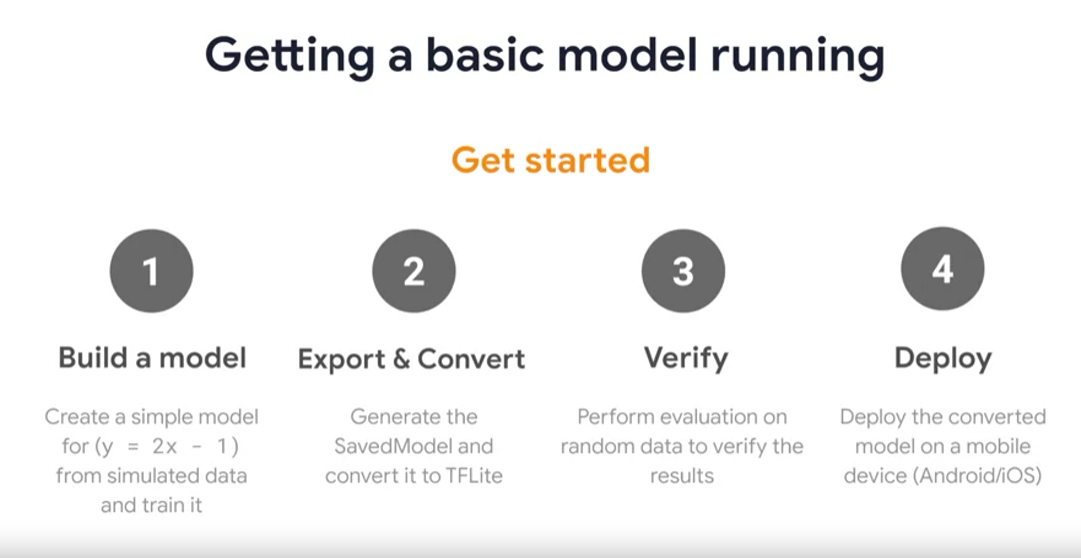

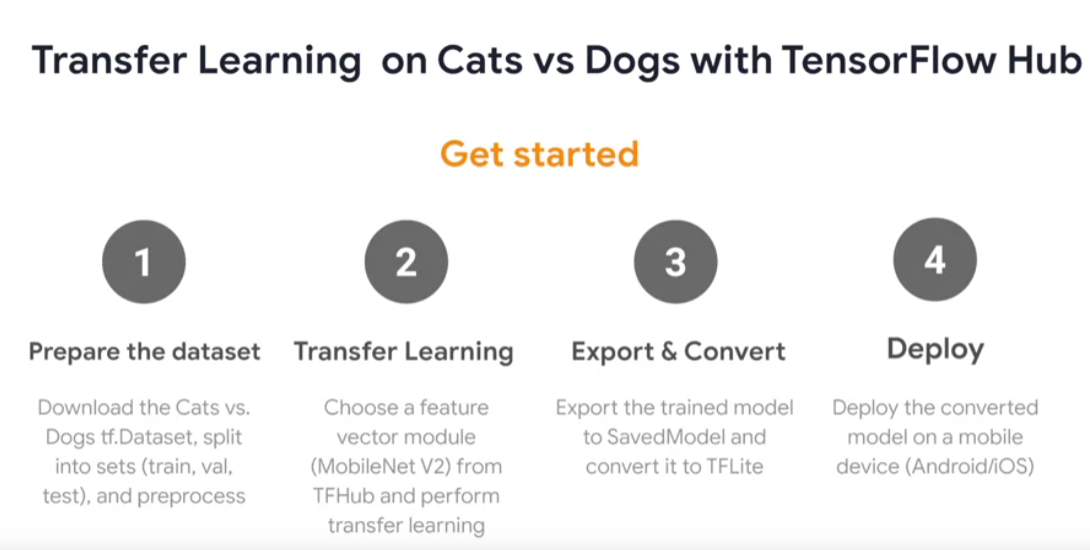

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Running TFLite Models

## Setup

In [ ]:
try:
    %tensorflow_version 2.x
except:
    pass

In [ ]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

print('\u2022 Using TensorFlow Version:', tf.__version__)

## Create a Basic Model of the Form y = mx + c

In [ ]:
# Create a simple Keras model.
x = [-1, 0, 1, 2, 3, 4]
y = [-3, -1, 1, 3, 5, 7]

model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(units=1, input_shape=[1])
])

model.compile(optimizer='sgd',
              loss='mean_squared_error')

model.fit(x, y, epochs=200)

## Generate a SavedModel

To export a SavedModel that was built with Keras or if it's one of the built-in ones, the process is as simple as calling tf.savedmodel.save, as you can see here. This will bundle all the weights as well as the model architecture. You can notice there's a safe path convention being followed which is used by TensorFlow Serving where the last path components, in this case, the number one is a version number for your model. It allows tools like TensorFlow Serving to pick the latest version by default to serve, thereby indicating its freshness.

In [ ]:
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

## Convert the SavedModel to TFLite

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
# you'll get the flattened version of the model that you can use what TensorFlow Lite

In [ ]:
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)
# Then finally you save out the TF Lite file by writing it to the file system. 
# You now have a model that can be deployed to Android, iOS, or Edge systems.

If I want to use a MobileNetV2 model that has been created for me, I can go through these steps.

In [ ]:
# import tensorflow as tf
# import pathlib

# # Load the MobileNet tf.keras model.
# model = tf.keras.applications.MobileNetV2(weights="imagenet", input_shape=(224, 224, 3))
# # Saving the model for later use by tflite_convert
# model.save('model.h5')

# # Convert the model
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model
# tflite_model_file = pathlib.Path('/tmp/foo.tflite')
# tflite_model_file.write_bytes(tflite_model)


If you don't have access to the Python code for generating the model, but you do have the saved model file, then the converter also works on the command line.

In [ ]:
# #!/usr/bin/env bash

# # Saving with the command-line from a SavedModel
# tflite_convert --output_file=model.tflite --saved_model_dir=/tmp/saved_model

# # Saving with the command-line from a Keras model
# tflite_convert --output_file=model.tflite --keras_model_file=model.h5

## Initialize the TFLite Interpreter To Try It Out

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
inputs, outputs = [], []
for _ in range(100):
    input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    
    interpreter.invoke()
    tflite_results = interpreter.get_tensor(output_details[0]['index'])
    
    # Test the TensorFlow model on random input data.
    tf_results = model(tf.constant(input_data))
    output_data = np.array(tf_results)
    
    inputs.append(input_data[0][0])
    outputs.append(output_data[0][0])

## Visualize the Model

In [ ]:
%matplotlib inline

plt.plot(inputs, outputs, 'r')
plt.show()

## Download the TFLite Model File

If you are running this notebook in a Colab, you can run the cell below to download the tflite model to your local disk. 

**Note**: If the file does not download when you run the cell, try running the cell a second time.

In [ ]:
try:
    from google.colab import files
    files.download(tflite_model_file)
except:
    pass

Catatan:

Investing with SavedModel's CLI code in terminal.
To understand the interfaces of signatures of a SavedModel, we can call the SavedModel CLI script and get details about it with code like this:

%saved_model_cli show --dir /tmp/mobilenet/1 \
                      --tag_set serve \
                      --signature_def serving_default

You'll see results like this:

The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1: 0
The given SavedModel SignatureDef contains the following output(s):
    outputs['act_softmax'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1000)
        nameL StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict

Explanation:
here, we can see that this model expects images to be input as 224 by 224 by 3. In other words, 24-bit color, 224 by 224 and their output is of shape 1,000 which tells me that it's classifying up to 1,000 classes. 
